In [6]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import GridSearchCV

import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub

import cv2

import Rakuten_preprocessing as rkt
from importlib import reload 
reload(rkt)

from Rakuten_preprocessing import Rakuten_img_path

ModuleNotFoundError: No module named 'spacy'

In [2]:
# gpus = tf.config.experimental.list_physical_devices('GPU')
# tf.config.experimental.set_visible_devices(gpus[1], 'GPU')

## Loading the data

In [3]:
folder_path = '../data/clean/'
data = pd.read_csv(os.path.join(folder_path, 'X_train.csv'), index_col=0)
target = pd.read_csv(os.path.join(folder_path, 'Y_train.csv'), index_col=0)
prdtype = pd.read_csv('../data/prdtype.csv', index_col='prdtypecode')
target = prdtype.loc[target['prdtypecode'], 'prdtypedesignation'].reset_index()

## Function to plot results

In [4]:
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, leaves_list

def plot_classification_results(y_true, y_pred, index=None):
    #Print evaluation metrics
    print(classification_report(y_true, y_pred))
    
    #Build confusion matrix
    conf_mat = pd.crosstab(y_true, y_pred, rownames=['Classes reelles'], colnames=['Classes predites'], normalize='columns')*100

    #in case labels are encoded, update with the original lables provided
    if index is not None:
        conf_mat.index = index
        conf_mat.columns = index
        
    #hierarchical clustering to find optimal order of labels
    Z = linkage(conf_mat, 'ward')
    order = leaves_list(Z)
    conf_mat = conf_mat.iloc[order, order]

    #plot confusion matrix as heatmap
    plt.figure(figsize=(15,12))
    sns.heatmap(conf_mat, annot=round(conf_mat,2), center=50, cmap=sns.color_palette('rocket',  as_cmap=True))
    plt.show()
    
    return plt

## Dataframe for Image Generator

In [5]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

#Encoding classes as integers
encoder = LabelEncoder()
labels = encoder.fit_transform(target['prdtypedesignation'])

#For windows
# img_folder = r"C:\Users\Julien Fournier\Documents\DST\RakutenProject\Data\images\image_train_resized"
#For wsl
img_folder = "/home/jul/DST/Rakuten/Data/images/image_train_resized"

img_paths = Rakuten_img_path(img_folder=img_folder,
                             imageid=data['imageid'], productid=data['productid'], suffix='_resized')

data_img = pd.DataFrame({'labels': labels, 'img_path': img_paths})

df_train, df_test = train_test_split(data_img, test_size=0.2, random_state=123, stratify=labels)

## Image generator

In [55]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import preprocess_input
import multiprocessing

img_size = (224, 224, 3)

def ViT_preprocess_input(x):
    x = x / 255.0  # Scale pixel values to 0-1
    x = x * 2 - 1  # Scale pixel values to -1 to 1
    return x

#Data generator for the train and test sets
train_data_generator = ImageDataGenerator(preprocessing_function=ViT_preprocess_input,
                                          rotation_range=20, width_shift_range=0.1, height_shift_range=0.1,
                                          horizontal_flip=True, fill_mode='constant', cval=0)

test_data_generator = ImageDataGenerator(preprocessing_function=ViT_preprocess_input, fill_mode='constant', cval=0)

train_generator = train_data_generator.flow_from_dataframe(dataframe=df_train, x_col='img_path', y_col='labels',
                                                           class_mode='raw', target_size=img_size[:2],
                                                           batch_size=64, use_multiprocessing=True, workers= 10)

test_generator = test_data_generator.flow_from_dataframe(dataframe=df_test, x_col='img_path', y_col='labels',
                                                           class_mode='raw', shuffle=False, target_size=img_size[:2],
                                                           batch_size=64, use_multiprocessing=True, workers= 10)

Found 67932 validated image filenames.
Found 16984 validated image filenames.


## Vision Transformer (ViT)

In [56]:
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Input
from keras.optimizers import Adam
from keras.optimizers.schedules import ExponentialDecay
from transformers import TFViTModel, ViTForImageClassification

num_class = len(np.unique(labels))

model_url = "https://www.kaggle.com/models/spsayakpaul/vision-transformer/frameworks/TensorFlow2/variations/vit-s16-fe/versions/1"
vit_model = hub.KerasLayer(model_url, trainable=True)

model = Sequential()
model.add(Input(shape=img_size))
model.add(vit_model)
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(units=num_class, activation='softmax'))

lr = 2e-5
optimizer = Adam(learning_rate=lr)
lr_schedule = ExponentialDecay(initial_learning_rate=2e-5, decay_steps=531, decay_rate=0.8)

model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_5 (KerasLayer)  (None, 384)               21665664  
                                                                 
 dense_10 (Dense)            (None, 128)               49280     
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_11 (Dense)            (None, 27)                3483      
                                                                 
Total params: 21718427 (82.85 MB)
Trainable params: 21718427 (82.85 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [57]:
history = model.fit(x=train_generator, validation_data=test_generator, epochs=10, verbose=True)

Epoch 1/10


W0000 00:00:1709200959.797935  873943 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 905/1062 [========================>.....] - ETA: 1:37 - loss: 2.0013 - accuracy: 0.4507

W0000 00:00:1709201550.177303  873986 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1062/1062 [==============================] - 772s 690ms/step - loss: 1.9313 - accuracy: 0.4664 - val_loss: 1.5010 - val_accuracy: 0.5657
Epoch 2/10
 782/1062 [=====================>........] - ETA: 2:50 - loss: 1.3764 - accuracy: 0.6012

W0000 00:00:1709202192.018037  873954 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1062/1062 [==============================] - 702s 661ms/step - loss: 1.3523 - accuracy: 0.6073 - val_loss: 1.3087 - val_accuracy: 0.6132
Epoch 3/10
1062/1062 [==============================] - 710s 668ms/step - loss: 1.1590 - accuracy: 0.6558 - val_loss: 1.1826 - val_accuracy: 0.6480
Epoch 4/10
1062/1062 [==============================] - 692s 651ms/step - loss: 1.0282 - accuracy: 0.6903 - val_loss: 1.1621 - val_accuracy: 0.6574
Epoch 5/10
1062/1062 [==============================] - 683s 643ms/step - loss: 0.9174 - accuracy: 0.7204 - val_loss: 1.1321 - val_accuracy: 0.6634
Epoch 6/10
1062/1062 [==============================] - 700s 659ms/step - loss: 0.8228 - accuracy: 0.7462 - val_loss: 1.1203 - val_accuracy: 0.6746
Epoch 7/10
1062/1062 [==============================] - 703s 661ms/step - loss: 0.7292 - accuracy: 0.7717 - val_loss: 1.1526 - val_accuracy: 0.6776
Epoch 8/10
1062/1062 [==============================] - 700s 659ms/step - loss: 0.6469 - accuracy: 0.7935 - val_loss: 1.148

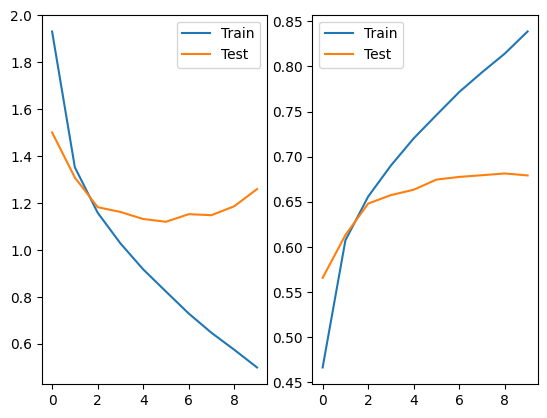

In [58]:
f, axs = plt.subplots(nrows=1, ncols=2)
axs[0].plot(history.history['loss'], label='Train')
axs[0].plot(history.history['val_loss'], label='Test')
axs[0].legend()

axs[1].plot(history.history['accuracy'], label='Train')
axs[1].plot(history.history['val_accuracy'], label='Test')
axs[1].legend()

plt.show()

In [59]:
test_pred = model.predict(x=test_generator)

266/266 [==============================] - 44s 160ms/step


              precision    recall  f1-score   support

           0       0.51      0.50      0.51       336
           1       0.59      0.50      0.54       165
           2       0.94      0.93      0.93       791
           3       0.69      0.76      0.73       161
           4       0.75      0.80      0.77       166
           5       0.51      0.35      0.41       153
           6       0.65      0.72      0.68       534
           7       0.67      0.79      0.73       998
           8       0.42      0.31      0.36       414
           9       0.72      0.80      0.76      1009
          10       0.59      0.74      0.65       502
          11       0.81      0.56      0.66       284
          12       0.79      0.34      0.47       174
          13       0.49      0.45      0.47       974
          14       0.86      0.85      0.85       861
          15       0.75      0.68      0.72       955
          16       0.87      0.33      0.48       552
          17       0.43    

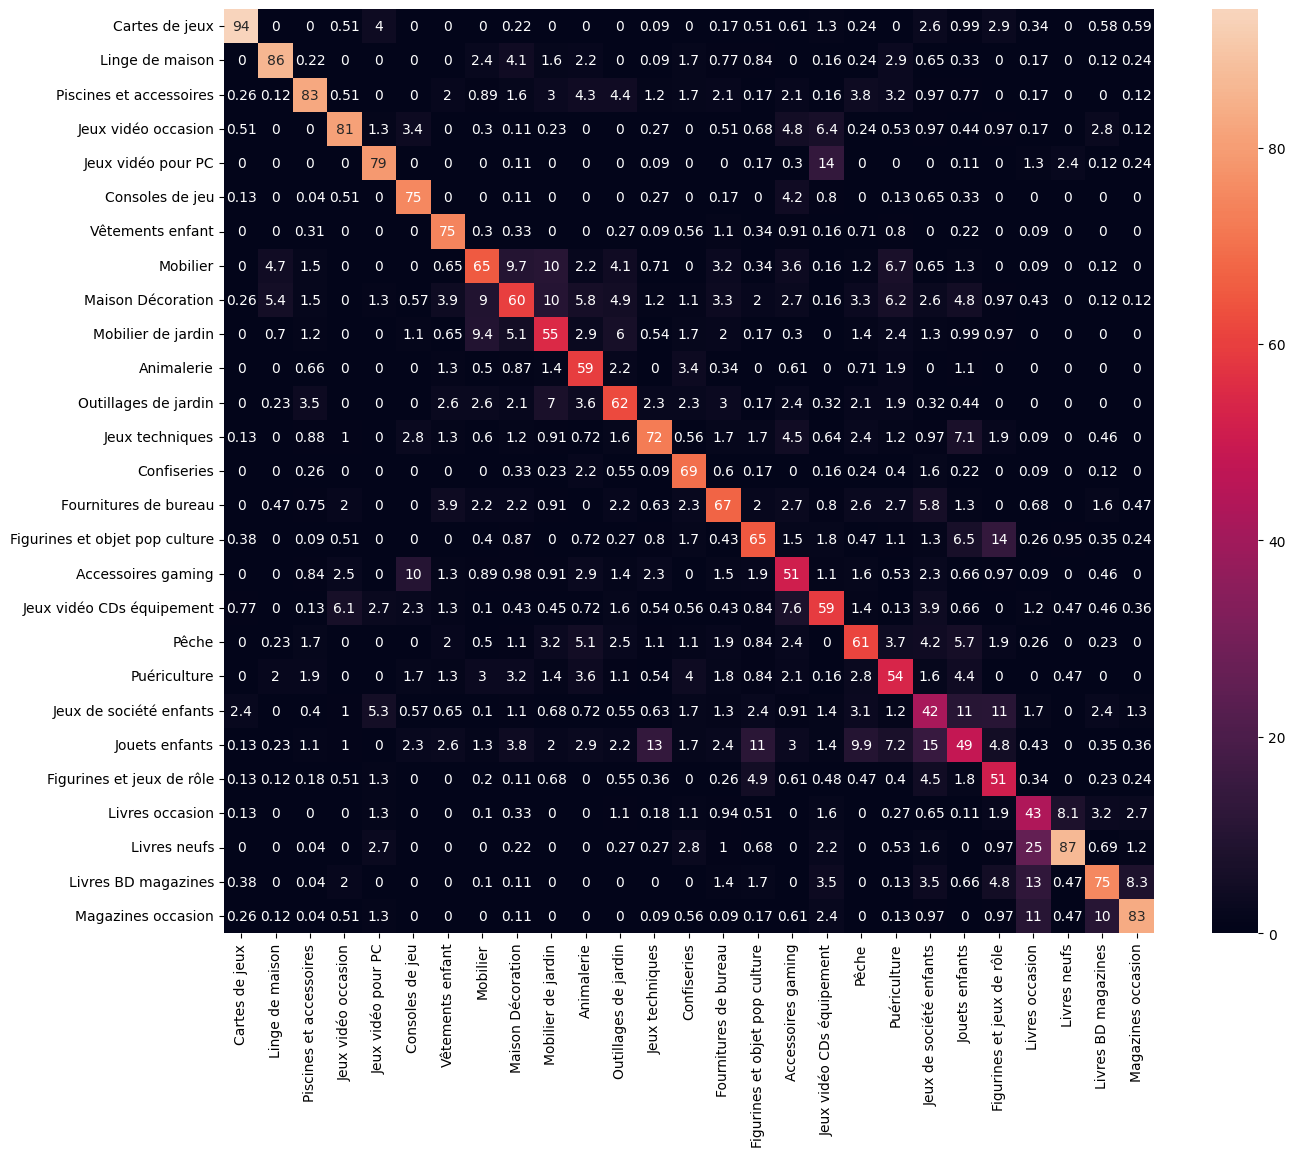

<module 'matplotlib.pyplot' from '/home/jul/anaconda3/envs/Rakuten/lib/python3.11/site-packages/matplotlib/pyplot.py'>

In [60]:
test_pred_class = np.argmax(test_pred, axis=1)
plot_classification_results(df_test['labels'], test_pred_class, index=encoder.classes_)

In [61]:
from sklearn.metrics import f1_score

f1_score(df_test['labels'], test_pred_class, average='weighted')

0.6741388991007558